In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
from google.colab.patches import cv2_imshow
%tensorflow_version 1.x
import torchvision.models as models
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL import Image
import torchvision.models as models
import torch
from collections import OrderedDict

from google.colab import drive
drive.mount('/content/drive')

TensorFlow 1.x selected.
Mounted at /content/drive


Iphone Data

In [3]:
foldername = "/content/drive/MyDrive/iphone_data/dataset_done/"
dataset = pd.read_csv(foldername + 'my_csv.csv', names=['id','piece','color'])
dataset = dataset.iloc[1:, ::2]
x = dataset.to_numpy()
for i in range(len(x)):
  x[i, 1] = int(x[i, 1]) - 1
dataset = pd.DataFrame(x, columns=['id','color'])
dataset = dataset[dataset['color'] > -1] 
dataset

,id,color
5,f7610259834.jpg,1
7,f2137846095.jpg,0
9,f0695374812.jpg,0
11,f9058461372.jpg,1
12,f9576230814.jpg,0
...,...,...
1140,f9784352061.jpg,1
1142,f2835976104.jpg,1
1143,f7913285604.jpg,1
1145,f1687034259.jpg,0


Labels: 

In [4]:
color_num_to_name = {
      0 : 'Orange',
      1 : 'Blue',
}

Uniform data:


In [5]:
def uniform(dataframe):
  dic = {}
  df = dataframe.sample(frac=1)
  for i in df['color']:
    if i not in dic:
      dic[i] = dic.get(i, 0)
    else:
      dic[i] += 1
  min_key = min(dic, key=dic.get)
  minimum = dic.get(min_key)
  dic2 = {}
  new = pd.DataFrame(columns = ['id', 'color'])
  for j in df['color']:
    if j not in dic2:
      pholder = df.loc[df['color']==j]
      pholder = pholder[:minimum]
      new = pd.concat([new,pholder], ignore_index=True)
      dic2[j] = dic2.get(j,0)
  return new

dataset = uniform(dataset)
dataset

,id,color
0,f7325189046.jpg,0
1,f1378456029.jpg,0
2,f1259840376.jpg,0
3,f1078259436.jpg,0
4,f9326817045.jpg,0
...,...,...
389,f9042817635.jpg,1
390,f8790123654.jpg,1
391,f5961283047.jpg,1
392,f8173260954.jpg,1


Split Dataset Into Train, Validation, Test

In [6]:
np.random.seed(123)


def data_split(N, ratio=[7, 2, 1]):
  shuffle_idx = np.arange(N)
  np.random.shuffle(shuffle_idx)
  data_split = (np.cumsum(ratio)/float(sum(ratio))*N).astype(int)
  out_idx = [None] * len(ratio)
  out_idx[0] = shuffle_idx[:data_split[0]]
  for i in range(1,len(ratio)):
    out_idx[i] = shuffle_idx[data_split[i-1] : data_split[i]]
  return out_idx  


split_idx = data_split(len(dataset))
df_train = dataset.loc[split_idx[0]]
df_valid = dataset.loc[split_idx[1]]
df_test = dataset.loc[split_idx[2]]

Creates a data loader for each piece

In [7]:
class ChessDataset(Dataset):
    def __init__(self, root_dir, df, transforms=None):
        self.root_dir = root_dir
        self.df = df
        self.file_names = df['id'].values
        self.targets = df['color'].values
        self.transforms = transforms
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        img_path = self.root_dir + self.file_names[index]
        img = Image.open(img_path)
        if self.transforms:
            img = self.transforms(img)
        target = self.targets[index]
        return img, target


transform_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    #transforms.Grayscale(3)
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Grayscale(3)
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


train_dataset = ChessDataset(foldername, df_train, transforms=transform_train)
valid_dataset = ChessDataset(foldername, df_valid, transforms=transform_test)
test_dataset = ChessDataset(foldername, df_test, transforms=transform_test)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

(tensor([[[0.6118, 0.6039, 0.6078,  ..., 0.4980, 0.4941, 0.4902],
          [0.6118, 0.6118, 0.6000,  ..., 0.4902, 0.4863, 0.4784],
          [0.6039, 0.6118, 0.6000,  ..., 0.4667, 0.4784, 0.4784],
          ...,
          [0.5647, 0.5569, 0.5608,  ..., 0.5843, 0.5765, 0.5725],
          [0.5804, 0.5725, 0.5647,  ..., 0.5882, 0.5843, 0.5765],
          [0.5922, 0.5843, 0.5725,  ..., 0.5922, 0.5804, 0.5725]],
 
         [[0.5451, 0.5373, 0.5412,  ..., 0.4275, 0.4235, 0.4196],
          [0.5451, 0.5451, 0.5333,  ..., 0.4196, 0.4157, 0.4078],
          [0.5373, 0.5451, 0.5333,  ..., 0.3961, 0.4078, 0.4078],
          ...,
          [0.5333, 0.5255, 0.5294,  ..., 0.5333, 0.5255, 0.5216],
          [0.5490, 0.5412, 0.5333,  ..., 0.5373, 0.5333, 0.5255],
          [0.5608, 0.5529, 0.5412,  ..., 0.5412, 0.5294, 0.5216]],
 
         [[0.4667, 0.4588, 0.4627,  ..., 0.3490, 0.3451, 0.3412],
          [0.4667, 0.4667, 0.4549,  ..., 0.3412, 0.3373, 0.3294],
          [0.4588, 0.4667, 0.4549,  ...,

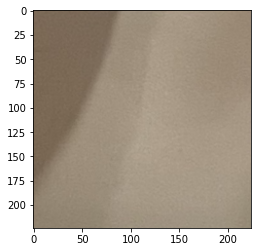

In [8]:
x = train_dataset[5][0]

plt.imshow(x.permute(1, 2, 0))

train_dataset[5]

MODEL

In [9]:
model = models.vgg16()
classifier = torch.nn.Sequential(OrderedDict([('fc1', torch.nn.Linear(25088, 5000)),
                                        ('relu', torch.nn.ReLU()),
                                        ('drop', torch.nn.Dropout(p=0.5)),
                                        ('fc2', torch.nn.Linear(5000, 2)),
                                        ('output', torch.nn.LogSoftmax(dim=1))]))
model.classifier = classifier

Sets up GPU or CPU

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(f'Using {device} device')

Using cuda device


Optimizer and Loss

In [11]:
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.001, momentum=0.9)
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Fuction for Validation Pass

In [12]:
def validation(model, validateloader, criterion):    
    val_loss = 0
    accuracy = 0
    for images, labels in iter(validateloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        val_loss += criterion(output, labels).item()
        probabilities = torch.exp(output)
        equality = (labels.data == probabilities.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
    return val_loss, accuracy

Training the classifier

In [13]:
def train_classifier():
        
        epochs = 300
        steps = 0
        print_every = 10
        model.to(device)
        for e in range(epochs):
            model.train()
            running_loss = 0
            for images, labels in iter(train_loader):
                steps += 1
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                output = model.forward(images)
                loss = criterion(output, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if steps % print_every == 0:
                    model.eval()
                
                    # Turn off gradients for validation, saves memory and computations
                    with torch.no_grad():
                        validation_loss, accuracy = validation(model, valid_loader, criterion)
            
                    print("Epoch: {}/{}.. ".format(e+1, epochs),
                          "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                          "Validation Loss: {:.3f}.. ".format(validation_loss/len(valid_loader)),
                          "Validation Accuracy: {:.3f}".format(accuracy/len(valid_loader)))
            
                    running_loss = 0
                    model.train()
                    
train_classifier()

Epoch: 1/300..  Training Loss: 0.693..  Validation Loss: 0.690..  Validation Accuracy: 0.682
Epoch: 1/300..  Training Loss: 0.688..  Validation Loss: 0.681..  Validation Accuracy: 0.518
Epoch: 1/300..  Training Loss: 0.681..  Validation Loss: 0.665..  Validation Accuracy: 0.516
Epoch: 2/300..  Training Loss: 0.340..  Validation Loss: 0.641..  Validation Accuracy: 0.546
Epoch: 2/300..  Training Loss: 0.635..  Validation Loss: 0.576..  Validation Accuracy: 0.555
Epoch: 2/300..  Training Loss: 0.545..  Validation Loss: 0.479..  Validation Accuracy: 0.686
Epoch: 2/300..  Training Loss: 0.437..  Validation Loss: 0.391..  Validation Accuracy: 0.848
Epoch: 3/300..  Training Loss: 0.366..  Validation Loss: 0.337..  Validation Accuracy: 0.923
Epoch: 3/300..  Training Loss: 0.345..  Validation Loss: 0.285..  Validation Accuracy: 0.925
Epoch: 3/300..  Training Loss: 0.289..  Validation Loss: 0.263..  Validation Accuracy: 0.923
Epoch: 4/300..  Training Loss: 0.093..  Validation Loss: 0.246..  Vali

KeyboardInterrupt: ignored

Validation on Test Set

In [14]:
def test_accuracy(model, test_loader):

    model.eval()
    model.to(device)
    with torch.no_grad():
        accuracy = 0
        for images, labels in iter(test_loader):
            images, labels = images.to(device), labels.to(device)
            output = model.forward(images)
            probabilities = torch.exp(output)
            equality = (labels.data == probabilities.max(dim=1)[1])
            accuracy += equality.type(torch.FloatTensor).mean()
        print("Test Accuracy: {}".format(accuracy/len(test_loader)))    
        
        
test_accuracy(model, test_loader)

Test Accuracy: 0.925000011920929


Saving the Trained Model

In [ ]:
def save_checkpoint(model):

    model.class_to_idx = train_dataset.class_to_idx

    checkpoint = {'arch': "vgg16",
                  'class_to_idx': model.class_to_idx,
                  'model_state_dict': model.state_dict()
                 }

    torch.save(checkpoint, 'checkpoint.pth')
    
save_checkpoint(model)